In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm as tqdm
import shapely
import cdsapi
import os
import glob
import pickle
import geopandas as gpd

import matplotlib.pyplot as plt
from geographiclib.geodesic import Geodesic

import gtc_functions

## API Working

In [3]:
### LOAD IN RELEVANT DFS FOR API CALLS
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/My Drive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/'

# xbd observation points
df_xbd_points_path = google_drive_personal_key + 'datasets/processed_data/metadata_pickle/lnglat_pre_pol_post_damage.pkl'
df_xbd_points_path = '/Users/orlandotimmerman/Desktop/lnglat_pre_pol_post_damage.pkl'
df_xbd_points = gtc_functions.standardise_xbd_obs_df(pd.read_pickle(df_xbd_points_path))
df_xbd_points.head()

,geometry,polygon_lnglat,point_xy,polygon_xy,disaster_name,image_name,capture_date,json_link,damage_class,lon,lat
0,POINT (-79.04236 33.58624),POLYGON ((-79.04246877521777 33.58619656219695...,POINT (21.859657142647336 11.540384007147074),"POLYGON ((0 23.07542987740177, 5.4400605824964...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.042360,33.586243
1,POINT (-79.04067 33.58624),POLYGON ((-79.04076716312134 33.58626511642874...,POINT (364.29112858833366 6.050993941743565),"POLYGON ((343.8285603480572 0, 343.67546136437...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.040667,33.586238
2,POINT (-79.03924 33.58618),POLYGON ((-79.03933584242897 33.58624243839649...,POINT (652.7525494937349 15.915749218488404),"POLYGON ((633.4092574824836 0, 636.30875820509...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039242,33.586175
3,POINT (-79.03905 33.58622),POLYGON ((-79.03914144408215 33.58623935704581...,POINT (692.2940274077046 4.47976753618199),"POLYGON ((672.7393984390319 0, 680.08814965569...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039045,33.586219
4,POINT (-79.03744 33.58610),POLYGON ((-79.03740598016368 33.58617995558616...,POINT (1017.8013436211089 27.135715154384336),"POLYGON ((1024 7.703541722778522, 1013.8706024...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.037438,33.586100


<AxesSubplot: >

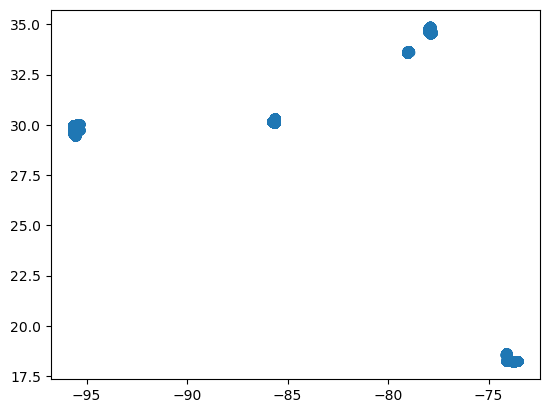

In [4]:
gdf = gpd.GeoDataFrame(df_xbd_points)

gdf.plot()

In [5]:
# xbd noaa 6-hourly
# df_xbd_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_xbd_hurricanes.pkl'

df_xbd_noaa_pkl_path = '/Users/orlandotimmerman/Desktop/noaa_xbd_hurricanes.pkl'
df_xbd_hurricanes_noaa = pd.read_pickle(df_xbd_noaa_pkl_path)

In [6]:
# generate information necessary for ecmwf api calls
event_api_info, start_end_dates, areas = gtc_functions.return_relevant_event_info(
	df_xbd_points, 
	df_xbd_hurricanes_noaa, 
	distance_buffer=6,
	verbose=True)

event_name: FLORENCE
min_date: 2018-09-14 06:00:00, max_date: 2018-09-15 12:00:00, event_area: [41.0, -84.0, 28.0, -73.0]
event_name: HARVEY
min_date: 2017-08-26 06:00:00, max_date: 2017-08-29 18:00:00, event_area: [36.0, -101.0, 23.0, -90.0]
event_name: MATTHEW
min_date: 2016-10-04 00:00:00, max_date: 2016-10-05 06:00:00, event_area: [25.0, -79.0, 12.0, -68.0]
event_name: MICHAEL
min_date: 2018-10-10 00:00:00, max_date: 2018-10-11 06:00:00, event_area: [37.0, -91.0, 24.0, -80.0]


In [153]:
# define weather parameters to request
weather_keys = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10']
weather_params = gtc_functions.return_full_weather_param_strings(weather_keys)

# call api to download ecmwf weather files
gtc_functions.fetch_era5_data(
	weather_params = weather_params, 
	start_end_dates = start_end_dates,
	areas = areas,
	download_dest_dir = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params'
	)

2023-03-14 23:58:09,014 INFO Welcome to the CDS
2023-03-14 23:58:09,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-14 23:58:09,143 INFO Request is completed
2023-03-14 23:58:09,156 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data3/adaptor.mars.internal-1678838258.843463-645-5-1b38a793-b2b7-4911-814b-24223cad3c34.grib to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params/14-09-2018_15-09-2018/2m_dewpoint_temperature.grib (1.6M)
2023-03-14 23:58:11,214 INFO Download rate 804.8K/s 
2023-03-14 23:58:11,377 INFO Welcome to the CDS
2023-03-14 23:58:11,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-14 23:58:11,455 INFO Request is queued
2023-03-14 23:58:12,509 INFO Request is running
2023-03-14 23

14-09-2018_15-09-2018.nc saved successfully


2023-03-15 00:02:41,884 INFO Welcome to the CDS
2023-03-15 00:02:41,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-15 00:02:42,130 INFO Request is queued
2023-03-15 00:02:43,176 INFO Request is running
2023-03-15 00:03:14,679 INFO Request is completed
2023-03-15 00:03:14,698 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data7/adaptor.mars.internal-1678838562.3497932-17165-7-5aada79b-3b10-444c-b9bb-64a68f401b0f.grib to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params/26-08-2017_29-08-2017/2m_dewpoint_temperature.grib (2.9M)
2023-03-15 00:03:16,669 INFO Download rate 1.5M/s   
2023-03-15 00:03:16,779 INFO Welcome to the CDS
2023-03-15 00:03:16,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-15 00:03

26-08-2017_29-08-2017.nc saved successfully


2023-03-15 00:10:14,857 INFO Request is queued
2023-03-15 00:10:15,908 INFO Request is running
2023-03-15 00:10:35,958 INFO Request is completed
2023-03-15 00:10:35,972 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.mars.internal-1678839015.175305-10871-15-752ae2c8-fef6-4af7-bb2b-946fb5071f5f.grib to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params/04-10-2016_05-10-2016/2m_dewpoint_temperature.grib (438.8K)
2023-03-15 00:10:37,595 INFO Download rate 270.6K/s
2023-03-15 00:10:38,043 INFO Welcome to the CDS
2023-03-15 00:10:38,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-15 00:10:38,258 INFO Request is queued
2023-03-15 00:10:39,337 INFO Request is running
2023-03-15 00:10:59,450 INFO Request is completed
2023-03-15 00:10:59,460 INFO Dow

04-10-2016_05-10-2016.nc saved successfully


2023-03-15 00:14:58,198 INFO Welcome to the CDS
2023-03-15 00:14:58,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-15 00:14:58,290 INFO Request is queued
2023-03-15 00:14:59,360 INFO Request is running
2023-03-15 00:15:19,483 INFO Request is completed
2023-03-15 00:15:19,497 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.mars.internal-1678839298.6404486-9045-18-6285f79f-6850-4549-8207-44f2c0e3d91d.grib to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params/10-10-2018_11-10-2018/2m_dewpoint_temperature.grib (1.7M)
2023-03-15 00:15:20,419 INFO Download rate 1.9M/s  
2023-03-15 00:15:20,589 INFO Welcome to the CDS
2023-03-15 00:15:20,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-15 

10-10-2018_11-10-2018.nc saved successfully


In [154]:
# group ecmwf xarray files into dictionary indexed by name of weather event
xbd_event_xa_dict = gtc_functions.generate_xbd_event_xa_dict('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/reduced_params',
	df_xbd_hurricanes_noaa)

100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


In [165]:
df_ecmwf_xbd_points = gtc_functions.determine_ecmwf_values_from_points_df(
	xbd_event_xa_dict,
	weather_keys = weather_keys,
	df_points = df_xbd_points,
	)

100%|██████████| 35501/35501 [17:09<00:00, 34.48it/s]  


In [166]:
df_ecmwf_xbd_points

,d2m,t2m,tp,sp,slhf,e,pev,ro,ssro,sro,u10,v10,xbd_index,name
0,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,0,FLORENCE
1,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,1,FLORENCE
2,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,2,FLORENCE
3,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,3,FLORENCE
4,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,4,FLORENCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108963,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108963,MICHAEL
108964,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108964,MICHAEL
108965,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108965,MICHAEL
108966,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108966,MICHAEL


In [168]:
df_xbd_ecmwf_dir = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf'
df_xbd_ecmwf_pkl_name = 'xbd_ecmwf_points'

gtc_functions.write_df_to_pkl(df_xbd_ecmwf_dir,
                                    df_xbd_ecmwf_pkl_name,
                                    df_ecmwf_xbd_points)

xbd_ecmwf_points.pkl written to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf


In [171]:
pd.read_pickle('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/xbd_ecmwf_points.pkl')

,d2m,t2m,tp,sp,slhf,e,pev,ro,ssro,sro,u10,v10,xbd_index,name
0,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,0,FLORENCE
1,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,1,FLORENCE
2,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,2,FLORENCE
3,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,3,FLORENCE
4,297.854736,302.468994,0.185841,101596.0625,18023580.0,0.007207,0.016479,0.150642,0.012798,0.137845,11.201935,10.804805,4,FLORENCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108963,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108963,MICHAEL
108964,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108964,MICHAEL
108965,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108965,MICHAEL
108966,298.310303,300.821777,0.063546,101373.2500,12943496.0,0.005176,0.007068,0.003163,0.002452,0.000746,13.636963,8.606812,108966,MICHAEL


# Visualisation

In [89]:
def plot_ecmwf_means(
	xa: xr.DataArray
):
	"""TODO: docstring"""
	num_plots = len(list(xa.data_vars))
	num_rows = int(np.ceil(num_plots / 2))

	fig, axes = plt.subplots(num_rows, 2, figsize=[16, 8*num_rows])
	axes = axes.ravel()
	
	# formatting
	plot_title = '_'.join((
			str(pd.to_datetime(xa.time.values.min()).date()), 
			str(pd.to_datetime(xa.time.values.max()).date())))
	plt.suptitle(plot_title)

	for i, weather_param in enumerate(list(xa.data_vars)):
		xa[weather_param].mean(dim=['time','step']).plot(ax=axes[i], x='longitude', y='latitude', cmap='coolwarm')

		units = xa[weather_param].attrs['GRIB_units']
		title = f'\n{gtc_functions.return_full_weather_param_strings([weather_param])[0]} ({units})'
		axes[i].set_title(title)

In [92]:
xbd_event_xa_dict['MATTHEW']

<xarray.Dataset>
Dimensions:     (latitude: 131, longitude: 111, step: 24, time: 3)
Coordinates:
  * latitude    (latitude) float64 25.0 24.9 24.8 24.7 ... 12.3 12.2 12.1 12.0
  * longitude   (longitude) float64 -79.0 -78.9 -78.8 ... -68.2 -68.1 -68.0
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    valid_time  (time, step) datetime64[ns] 2016-10-03T01:00:00 ... 2016-10-06
  * time        (time) datetime64[ns] 2016-10-03 2016-10-04 2016-10-05
    number      int32 0
    surface     float64 0.0
Data variables:
    ssro        (time, step, latitude, longitude) float32 nan nan ... nan nan
    sro         (time, step, latitude, longitude) float32 nan nan ... nan nan
    ro          (time, step, latitude, longitude) float32 nan nan ... nan nan
    t2m         (time, step, latitude, longitude) float32 nan nan ... nan nan
    tp          (time, step, latitude, longitude) float32 nan nan ... nan nan
    slhf        (time, step, latitude, longitude) float32 nan nan ... nan nan
    d2m         (time, step, latitude, longitude) float32 nan nan ... nan nan
    u10         (time, step, latitude, longitude) float32 nan nan ... nan nan
    v10         (time, step, latitude, longitude) float32 nan nan ... nan nan
    sp          (time, step, latitude, longitude) float32 nan nan ... nan nan
    e           (time, step, latitude, longitude) float32 nan nan ... nan nan
    pev         (time, step, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-03-14T22:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [111]:
xbd_event_xa_dict['MATTHEW']['ssro'].step

<xarray.DataArray 'step' (step: 24)>
array([ 3600000000000,  7200000000000, 10800000000000, 14400000000000,
       18000000000000, 21600000000000, 25200000000000, 28800000000000,
       32400000000000, 36000000000000, 39600000000000, 43200000000000,
       46800000000000, 50400000000000, 54000000000000, 57600000000000,
       61200000000000, 64800000000000, 68400000000000, 72000000000000,
       75600000000000, 79200000000000, 82800000000000, 86400000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * step     (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    number   int32 0
    surface  float64 0.0
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [104]:
xbd_event_xa_dict['MATTHEW']['ssro'].isel(time=0).isel(step=0)

<xarray.DataArray 'ssro' (latitude: 131, longitude: 111)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude    (latitude) float64 25.0 24.9 24.8 24.7 ... 12.3 12.2 12.1 12.0
  * longitude   (longitude) float64 -79.0 -78.9 -78.8 ... -68.2 -68.1 -68.0
    step        timedelta64[ns] 01:00:00
    valid_time  datetime64[ns] 2016-10-03T01:00:00
    time        datetime64[ns] 2016-10-03
    number      int32 0
    surface     float64 0.0
Attributes: (12/30)
    GRIB_paramId:                             9
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      14541
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_shortName:                           ssro
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Sub-surface runoff
    units:                                    m
    standard_name:                            unknown

In [130]:
def plot_ecmwf_parameters(
	xa: xr.DataArray
):
	num_cols = len(list(xa.data_vars))
	num_rows = len(list(xa.time)) * 24 

	fig, axes = plt.subplots(num_rows, 1, figsize=[2*num_cols, 2*num_rows])
	axes = axes.ravel()

	for i, weather_param in tqdm.tqdm(enumerate(list(xa.data_vars)[:1])):
		for t, time in enumerate(list(xa.time)[:5]):
			for s, step in enumerate(list(xa.step)[:5]):
				array = xa[weather_param].isel(time=t).isel(step=s)
				im = array.plot(ax=axes[i+t+s], x='longitude', y='latitude', cmap='coolwarm')

				# 	# formatting
				# plot_title = '_'.join((
				# 	str(pd.to_datetime(time.date)), 
				# 	str(pd.to_datetime(time.date))))
				# plt.suptitle(plot_title)
				units = xa[weather_param].attrs['GRIB_units']
				title = f'\n{gtc_functions.return_full_weather_param_strings([weather_param])[0]} ({units})'
				axes[i+t+s].set_title(title)

	fig.colorbar(im, ax=axes.tolist())



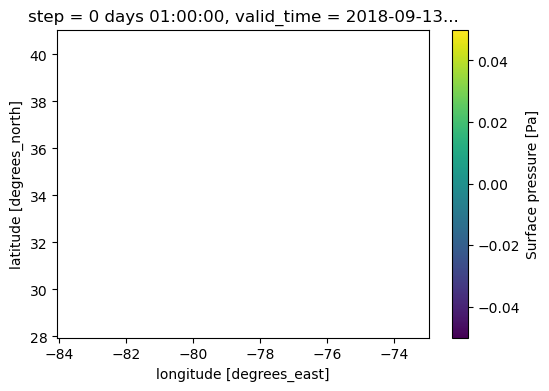

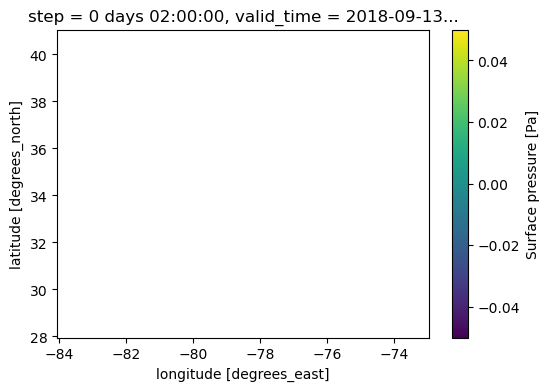

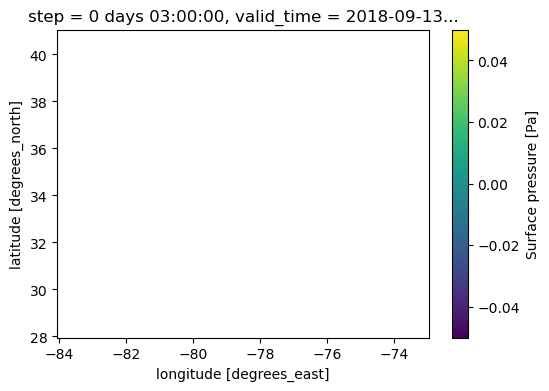

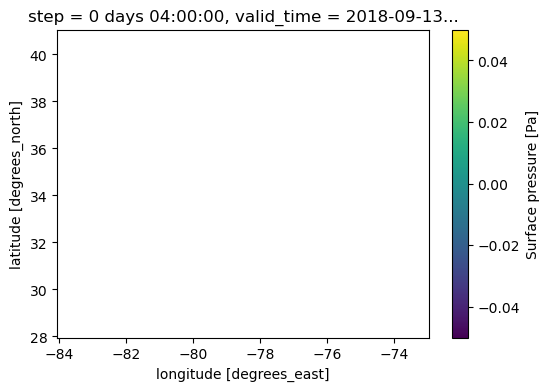

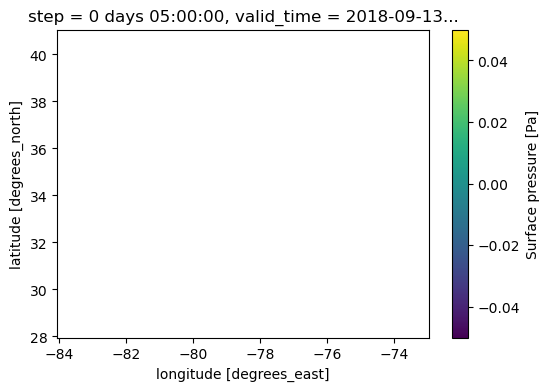

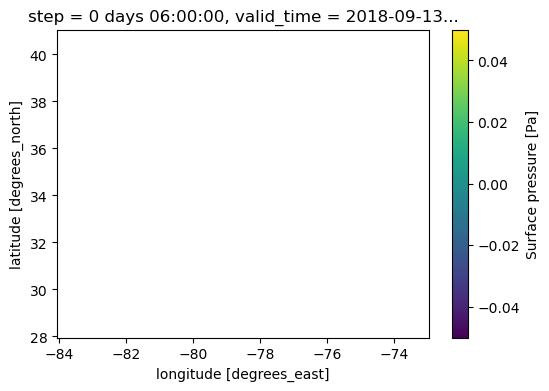

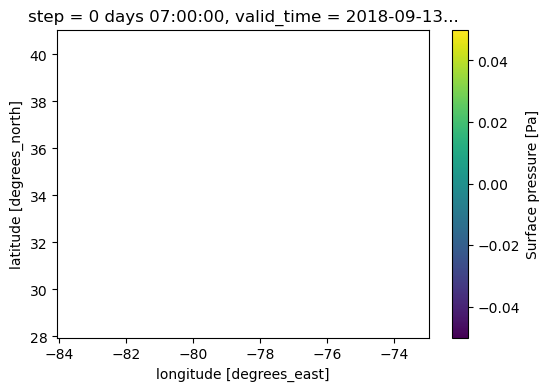

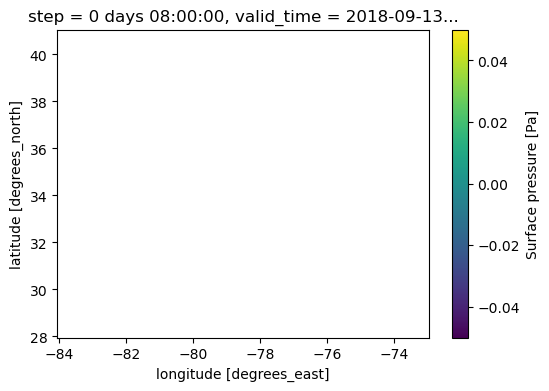

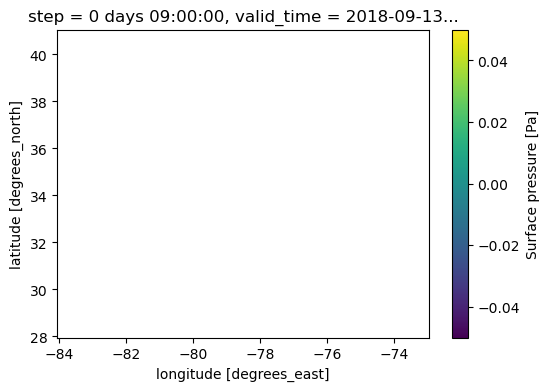

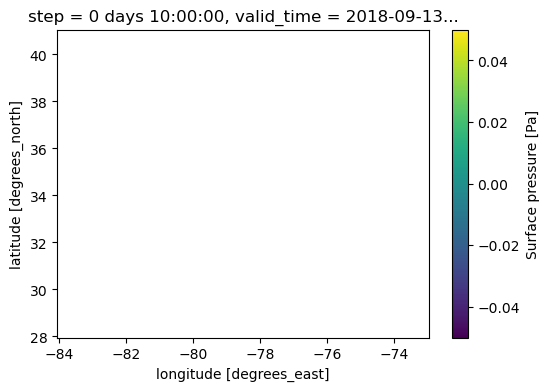

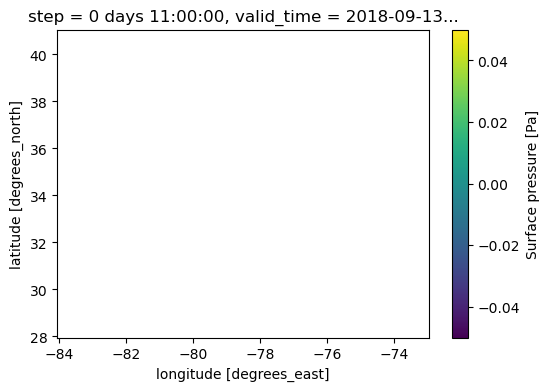

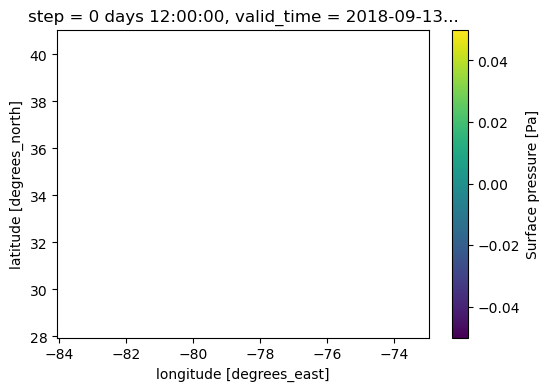

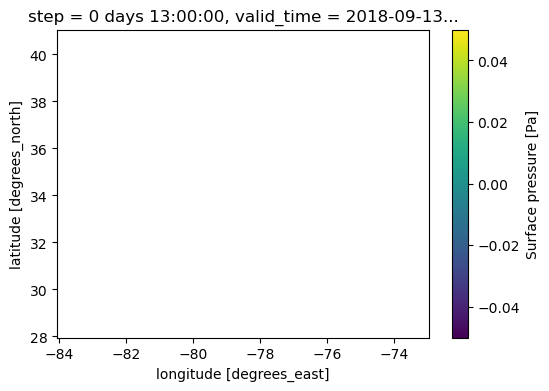

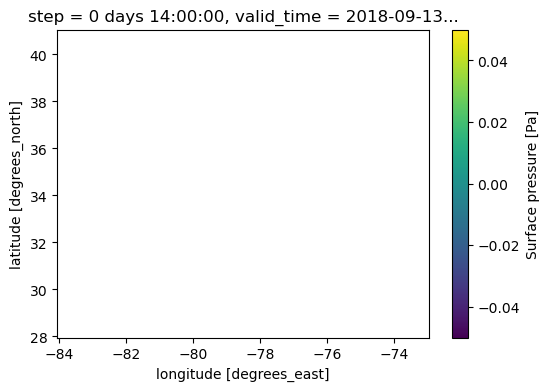

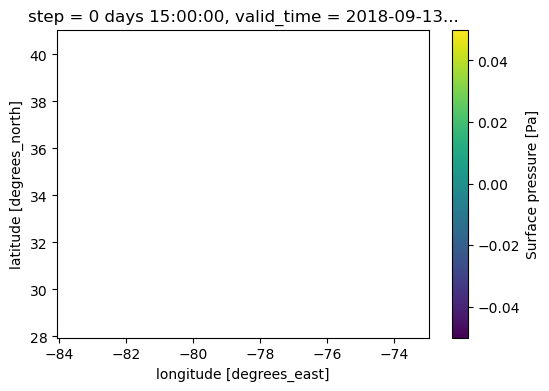

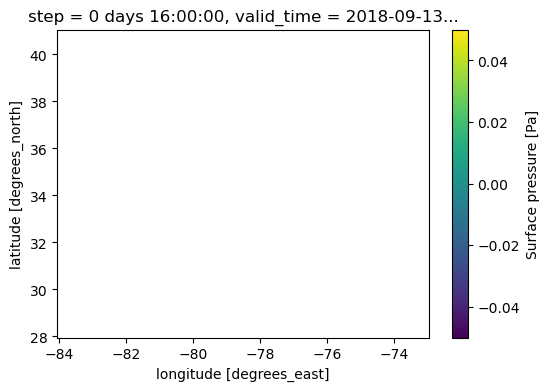

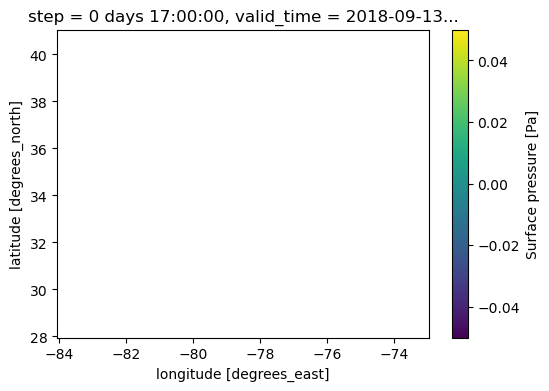

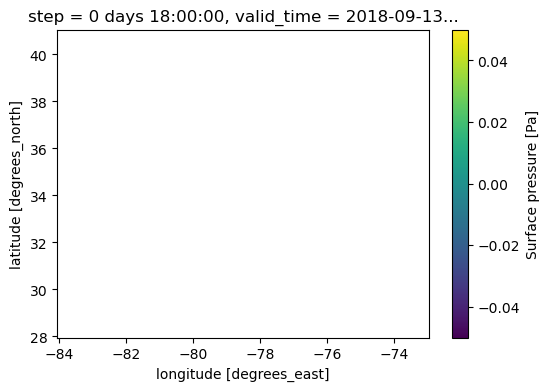

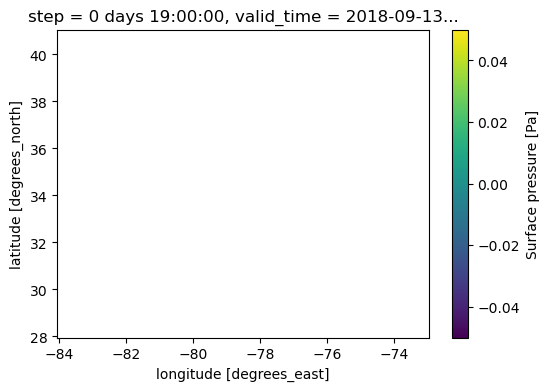

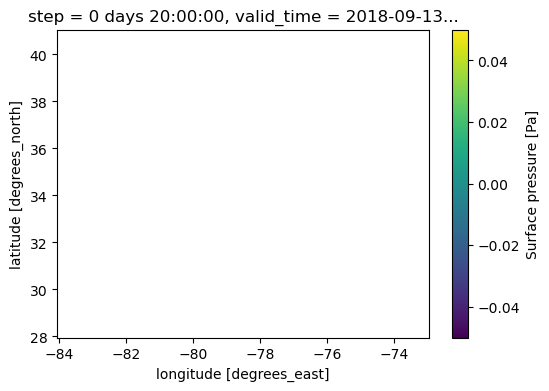

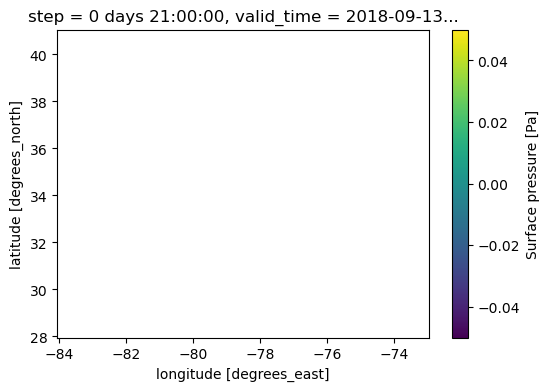

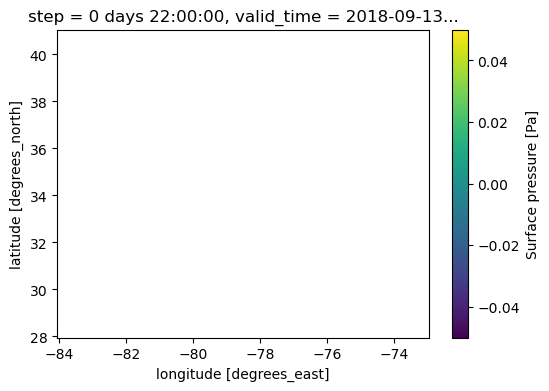

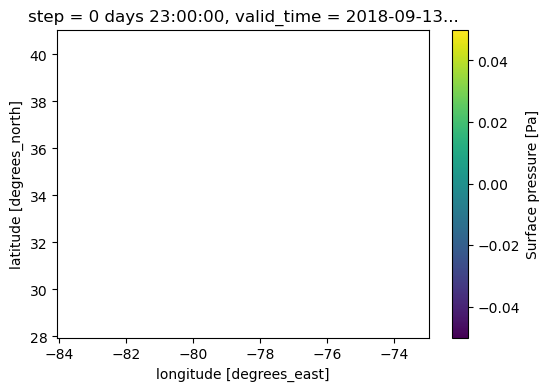

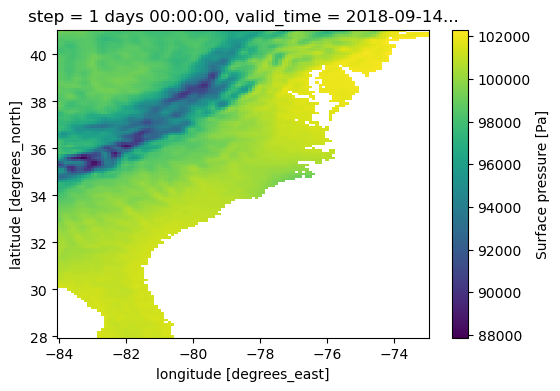

In [149]:
for i in range(24):
	# xbd_event_xa_dict['MATTHEW']['d2m'][i]
	xbd_event_xa_dict['FLORENCE']['sp'][0,:,:][i].plot(x='longitude', y='latitude', figsize=(6,4))

1it [00:01,  1.15s/it]


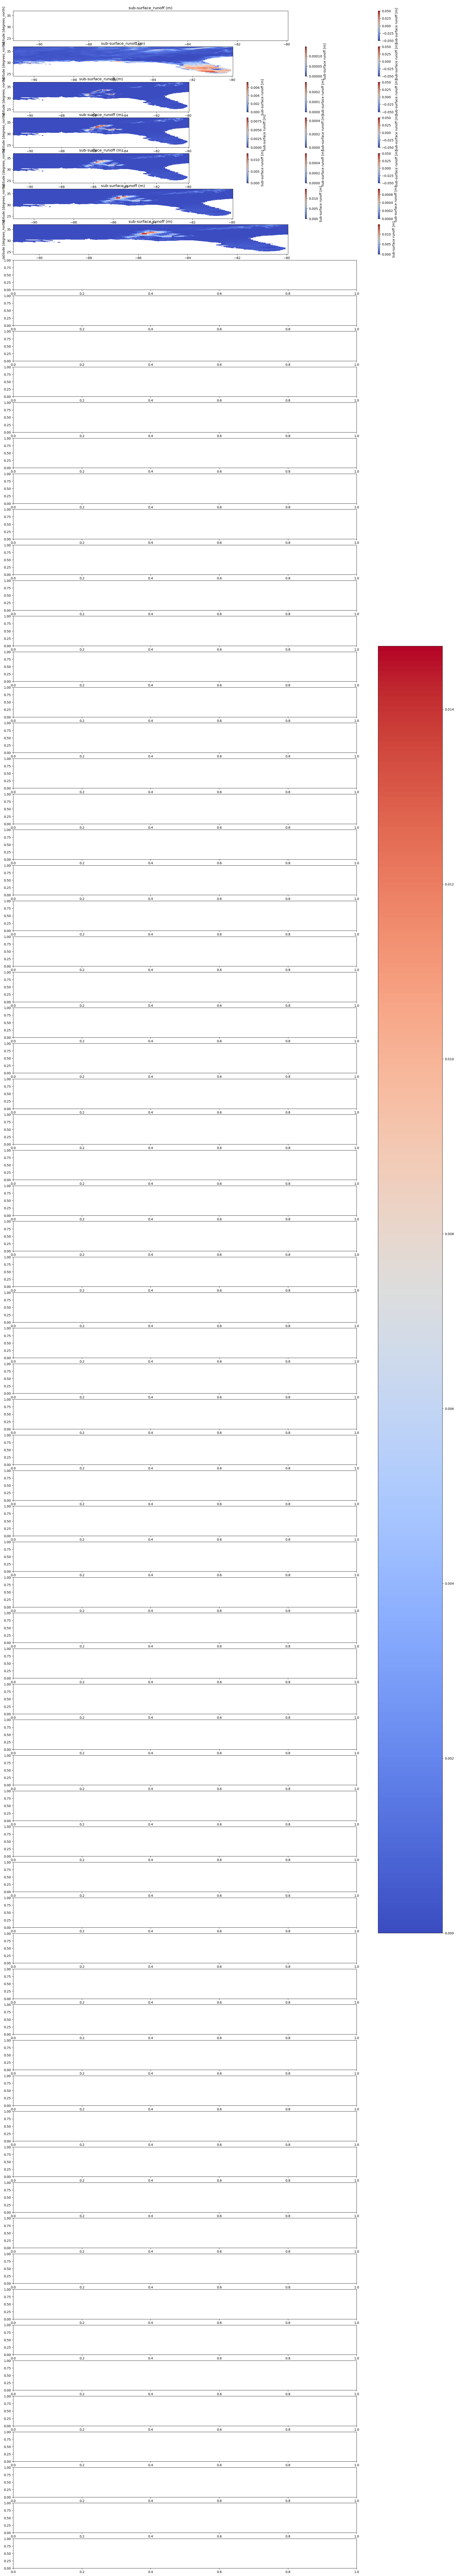

In [131]:
plot_ecmwf_parameters(xbd_event_xa_dict['MICHAEL'])

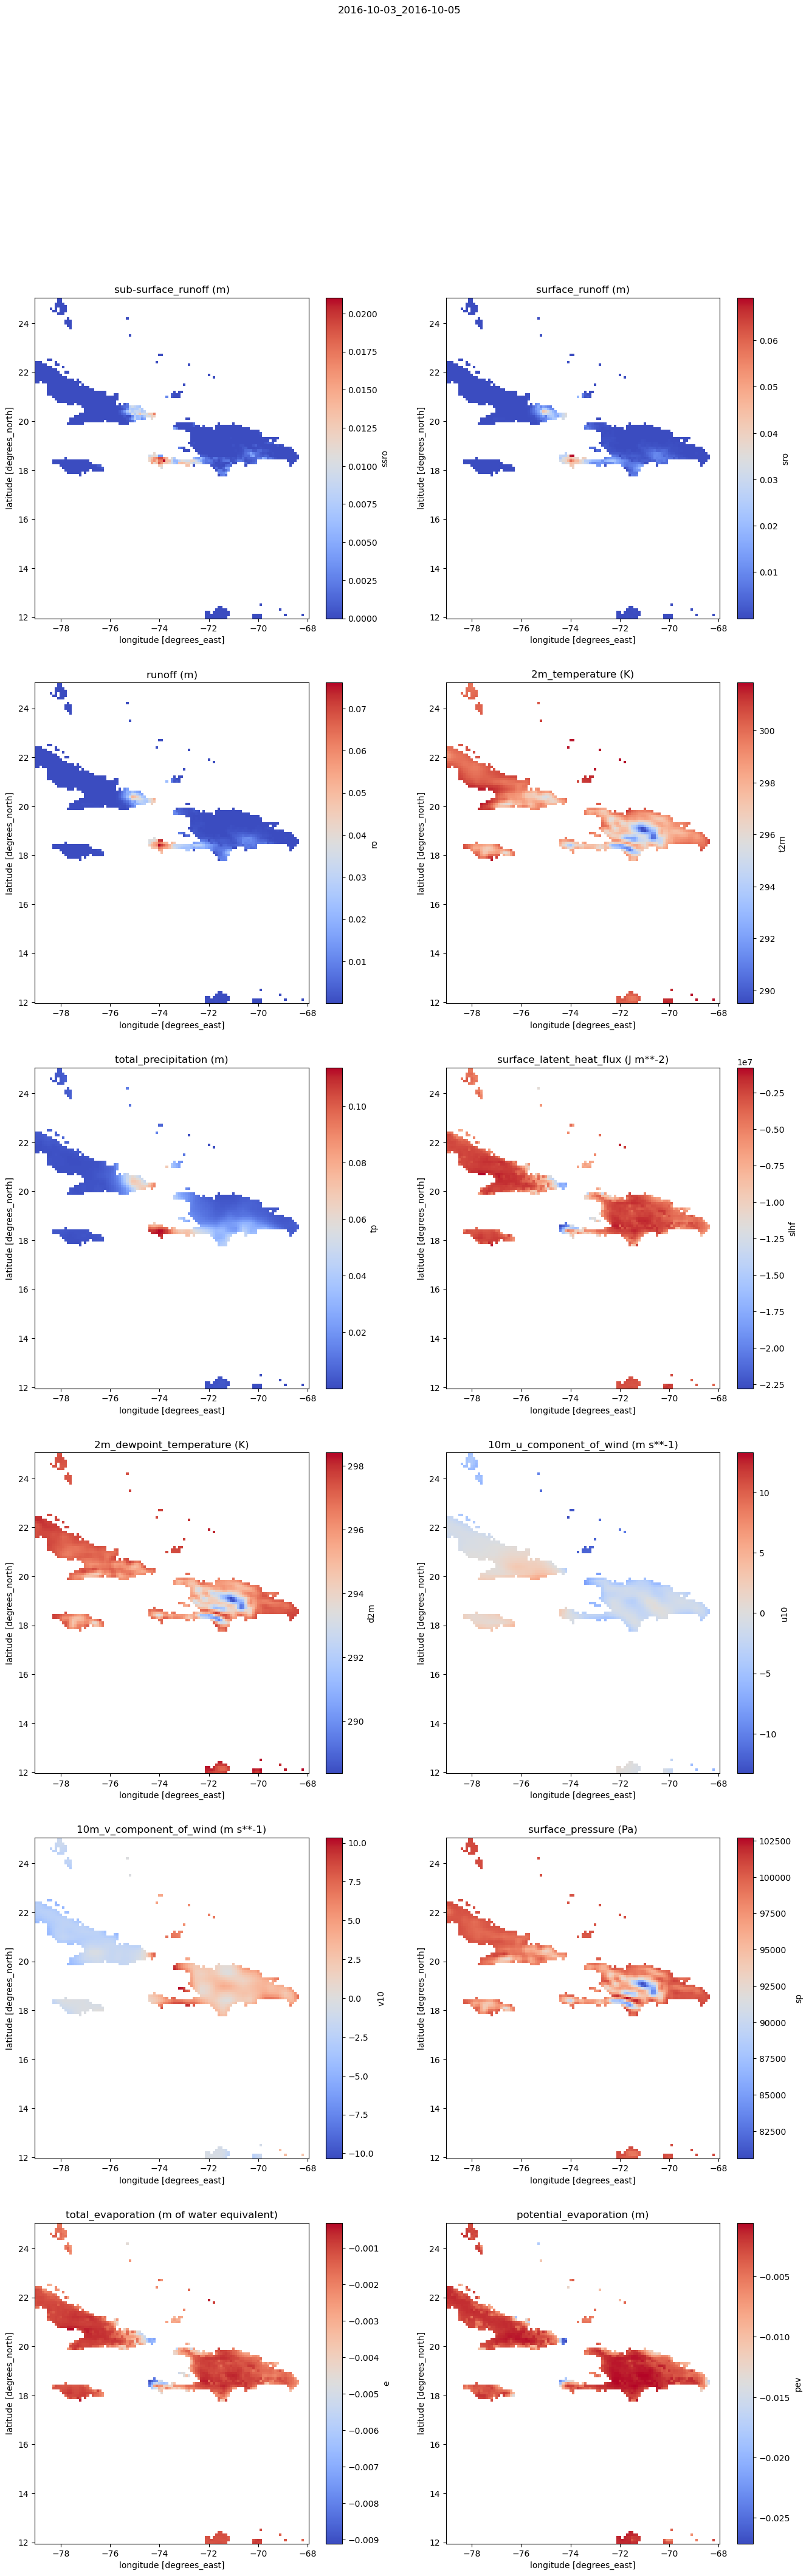

In [141]:
plot_ecmwf_means(xbd_event_xa_dict['MATTHEW'])

In [11]:
single = xr.load_dataset('/Users/orlandotimmerman/Downloads/adaptor.mars.internal-1678809860.676-330-6-615c35e8-714e-419f-b3a8-7cb2d55f1543.grib', engine='cfgrib')
test_xa = xr.load_dataset('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/04-10-2016_05-10-2016.nc')

/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


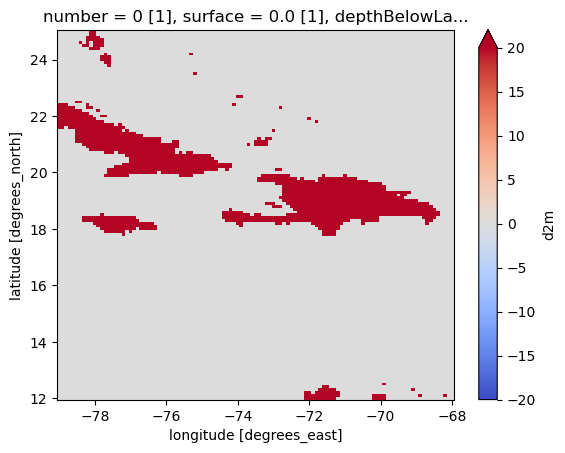

In [18]:
test_xa['d2m'].sum(dim=['time','step']).plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20)

In [41]:
test_xa['u10'].attrs['GRIB_units']

'm s**-1'

In [68]:
test_xa['u10'].coords

Coordinates:
  * latitude             (latitude) float64 25.0 24.9 24.8 ... 12.2 12.1 12.0
  * longitude            (longitude) float64 -79.0 -78.9 -78.8 ... -68.1 -68.0
    valid_time           (time, step) datetime64[ns] 2016-10-03T01:00:00 ... NaT
  * time                 (time) datetime64[ns] 2016-10-03 ... 2016-10-05T23:0...
  * step                 (step) timedelta64[ns] 01:00:00 ... 1 days 00:00:00
    number               int32 0
    surface              float64 0.0
    depthBelowLandLayer  float64 28.0

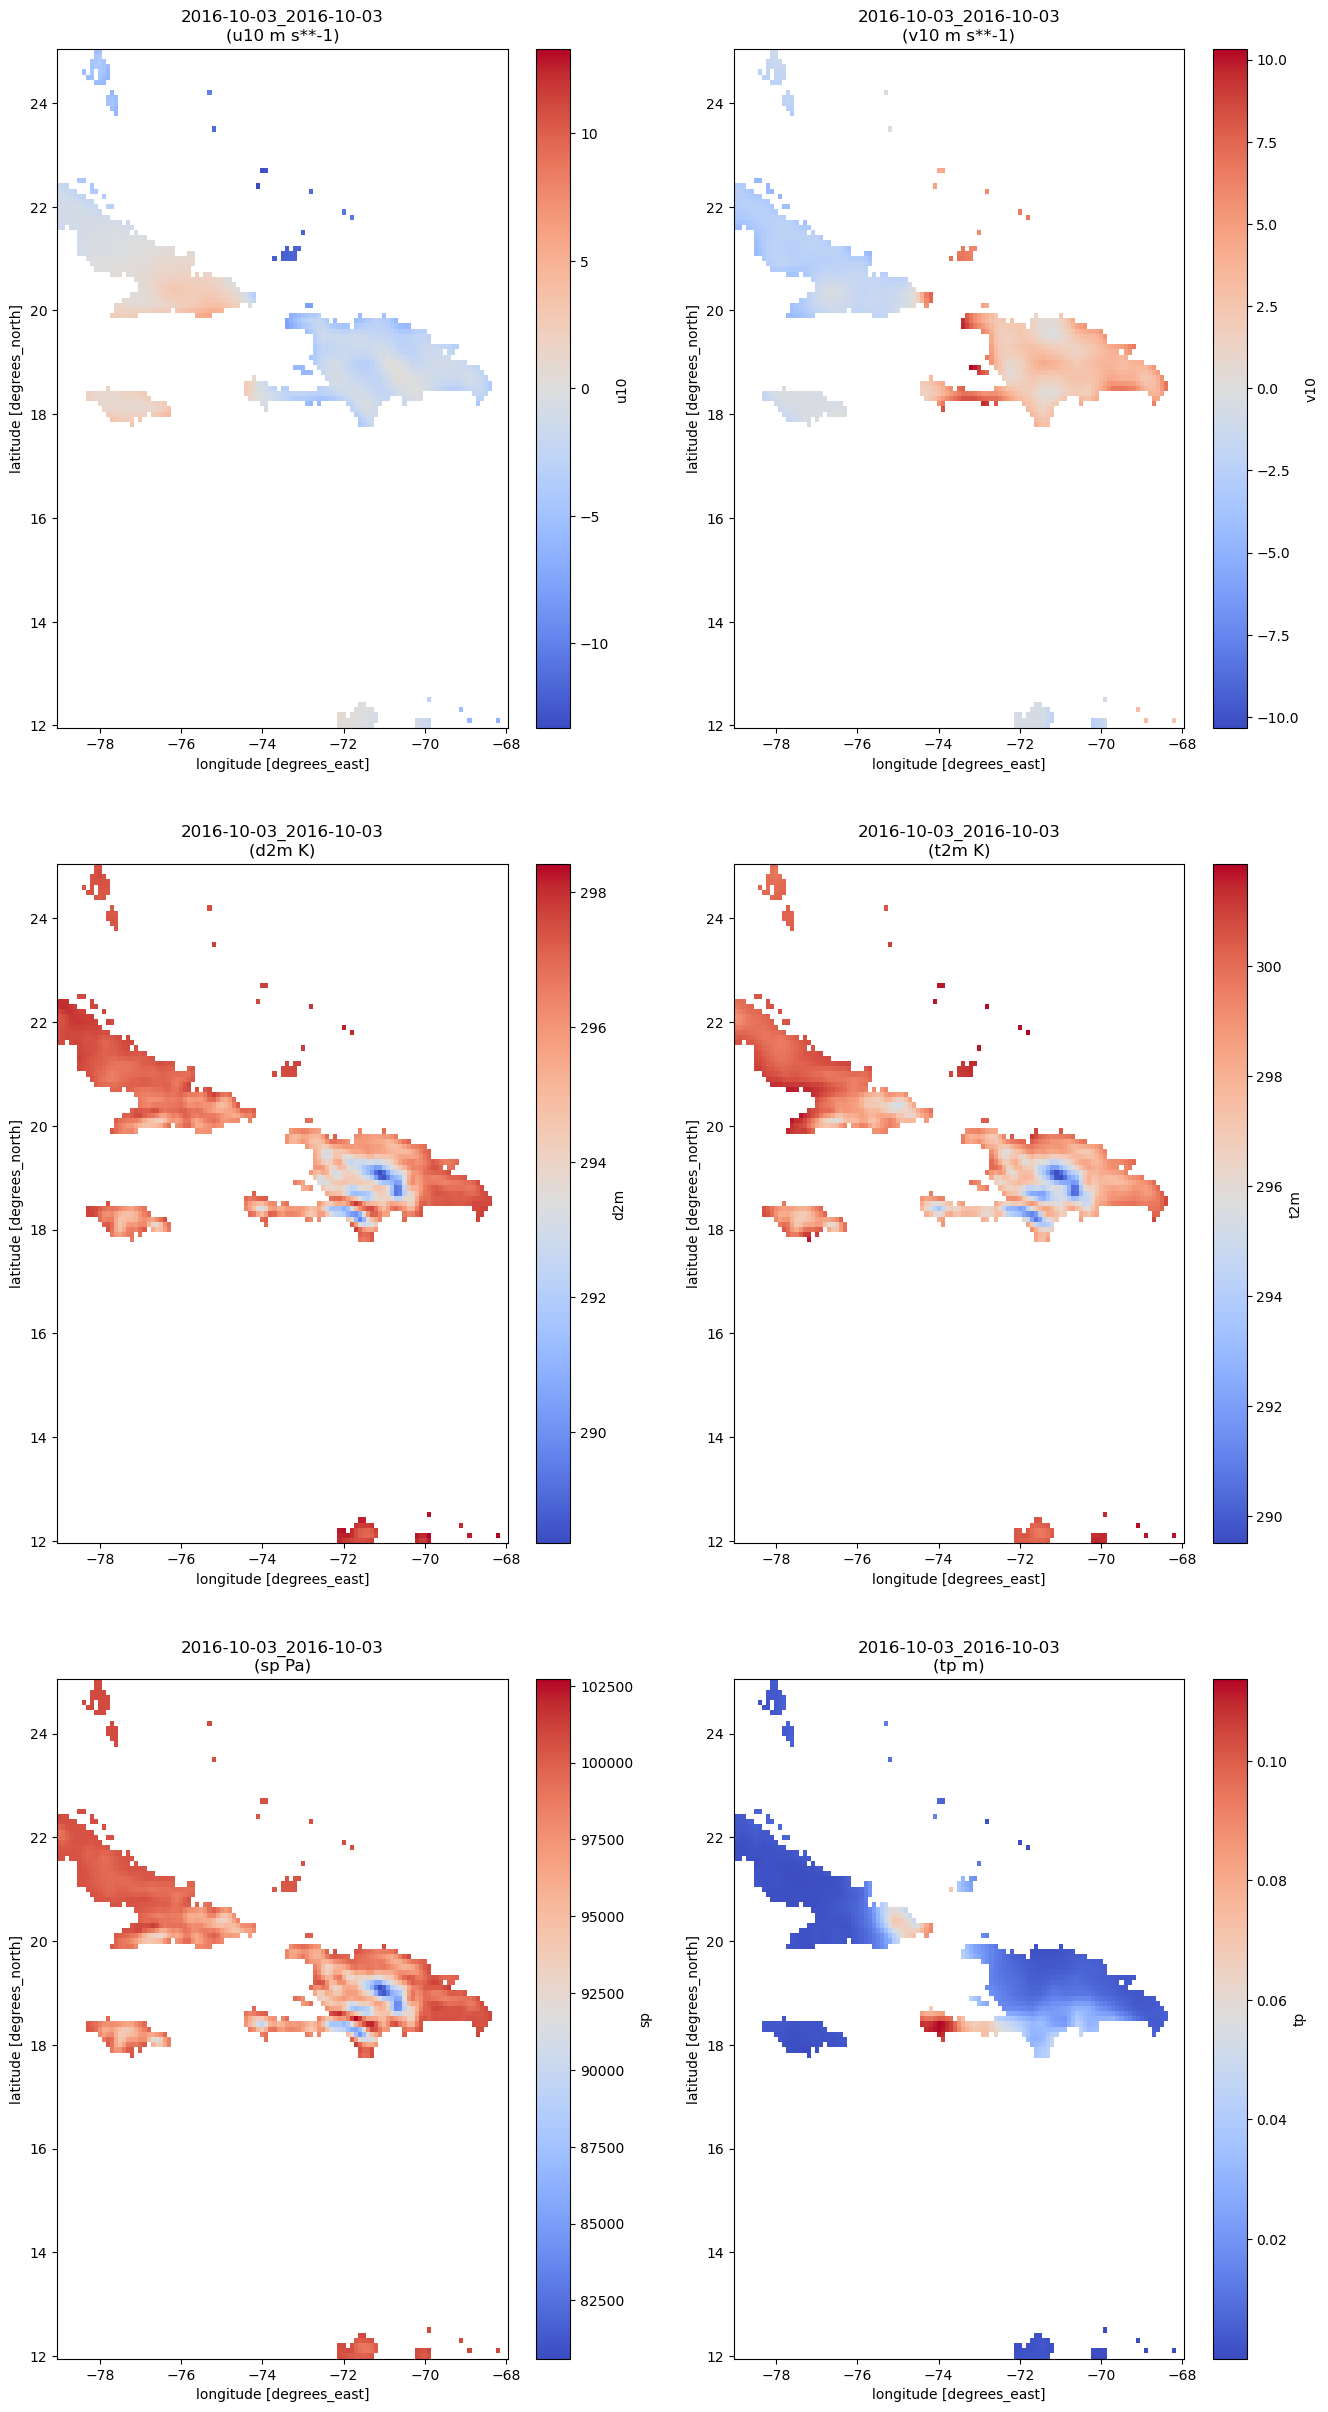

In [48]:
# num_plots = len(test_xa.data_vars)
weathers = ['u10', 'v10', 'd2m', 't2m', 'sp', 'tp']


num_plots = len(weathers)
num_rows = int(np.ceil(num_plots / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=[16, 10*num_rows])
axes = axes.ravel()


# for i, weather_param in enumerate(list(test_xa.data_vars)):
for i, weather_param in enumerate(weathers):

	# test_xa[weather_param].sum(dim=['time','step']).plot(ax=axes[i], x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20)
	# do some not have steps???
	test_xa[weather_param].mean(dim=['time','step']).plot(ax=axes[i], x='longitude', y='latitude', cmap='coolwarm')

	date_string = '_'.join((
		str(pd.to_datetime(test_xa[weather_param].time.values.min()).date()), 
		str(pd.to_datetime(test_xa[weather_param].time.values.min()).date())))
	units = test_xa[weather_param].attrs['GRIB_units']
	title = date_string + f'\n{weather_param} ({units})'
	axes[i].set_title(title)



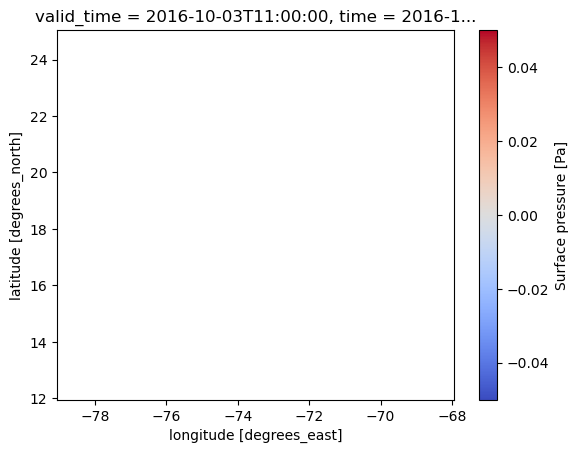

In [34]:
test_xa['sp'][0][10].plot(x='longitude', y='latitude', cmap='coolwarm')

In [ ]:
single['d2m'].sum(dim=['time','step']).plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20, figsize=(6,4))

In [ ]:
np.shape(single['d2m'][0][4].values)

In [ ]:
single['d2m'][0][4].values


In [ ]:
np.add(np.arange(9.0).reshape((3, 3)),np.arange(9.0).reshape((3, 3)))

In [ ]:
np.arange(9.0).reshape((3, 3))+np.arange(9.0).reshape((3, 3))

In [ ]:
single['d2m'][0][7].plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20, figsize=(6,4))

In [ ]:
test_data['t2m'][0][20].plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20, figsize=(6,4))

In [ ]:
# test_xa = xr.load_dataset('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/14-09-2018_15-09-2018/2m_temperature.grib')
test_xa = xr.load_dataset('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/ecmwf/api/04-10-2016_05-10-2016/2m_temperature.grib')
test_xa['t2m'][0].plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20, figsize=(6,4))

In [160]:
# this is taking forever with the bigger dataframe. May have to chunk it.
df_ecmwf_xbd_points = gtc_functions.determine_weather_values_from_points_df(
	xbd_event_xa_dict,
	weather_keys = weather_keys,
	df_points = df_xbd_points,
	)

  0%|          | 0/11548 [00:00<?, ?it/s]


KeyError: "None of [Index(['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation',\n       'surface_pressure', 'surface_latent_heat_flux', 'total_evaporation',\n       'potential_evaporation', 'runoff', 'sub-surface_runoff',\n       'surface_runoff', '10m_u_component_of_wind', '10m_v_component_of_wind'],\n      dtype='object')] are in the [columns]"

# TODO: Visualisation of weather data

In [ ]:
u10[0][0].plot(x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20, figsize=(6,4))

In [ ]:
len(u10.step)

In [ ]:
num_side = 2
fig,axs = plt.subplots(num_side, num_side)
axs = axs.ravel()

plt.rcParams.update({'font.size': 6})

for i in range(num_side**2):
	# iterate over day
	for d in u10.time:
		# iterate over step
		for s in u10.step:
			u10_data = u10.sel(time=d,step=s)
			u10_data.plot(ax=axs[i], x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20)
			
			# u10[i][0].plot(ax=axs[i], x='longitude', y='latitude', cmap='coolwarm', vmin=-20, vmax=20)


In [ ]:
for i in range(5):
    var_data[i,:,:].plot(x='longitude', y='latitude', figsize=(6,4))
    plt.show()
    plt.close()

In [ ]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

var_data = ds['u10']


# Plot the initial frame. 
cax = var_data[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-40, vmax=40,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(var_data[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(var_data.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs

var_data = ds['u10']

# Create a figure and axis using cartopy
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define a function to update the plot for each time step
def update_plot(i):
    # Clear the axis for the new plot
    ax.clear()

    # Plot the variable data for the current time step
    var_data.isel(time=i).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add a title and annotation for the current time step
    ax.set_title('Variable Data at Time: {}'.format(var_data.time.values[i]), fontsize=14)
    ax.annotate('Time: {}'.format(var_data.time.values[i]), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

    # Set the axis extent and gridlines
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', draw_labels=True)

# Create an animation object
ani = animation.FuncAnimation(fig, update_plot, frames=len(var_data.time), repeat=True)

# Save the animation as an mp4 file
ani.save('your_animation.mp4', writer='ffmpeg')
